<a href="https://colab.research.google.com/github/pstanisl/mlprague-2021/blob/main/05_CMAB_movielens_linear_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Contextual Multi-Armed Bandits 

From now we will use [TensorFlow Agents](https://www.tensorflow.org/agents), so so it's probably appropriate to say something about this library. Agents is a library for reinforcement learning in TensorFlow.  

> TF-Agents makes designing, implementing, and testing new RL algorithms easier by providing well-tested modular components that can be modified and extended. It enables fast code iteration with good test integration and benchmarking.

It provides API for creating all aspects necessary for reinforcement learning with Tensorflow, example of API can be seen below.

```python
import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent

q_net = q_network.QNetwork(
  train_env.observation_spec(),
  train_env.action_spec(),
  fc_layer_params=(100,))

agent = dqn_agent.DqnAgent(
  train_env.time_step_spec(),
  train_env.action_spec(),
  q_network=q_net,
  optimizer=optimizer,
  td_errors_loss_fn=common.element_wise_squared_loss,
  train_step_counter=tf.Variable(0))

agent.initialize()
```

As Multi-Armed Bandits can be seen as a special case of RL, TF-Agents contains also building blocks for MAB, especially for Contextual Multi-Armed Bandits (CMAB). ☺️


#### Installation

In [1]:
!pip install tf-agents -q

     |████████████████████████████████| 1.2MB 9.5MB/s 


In [2]:
!rm -f ./utils.py
!wget --no-check-certificate --no-cache --no-cookies \
    https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py \
    -O ./utils.py

--2021-02-25 15:03:50--  https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4245 (4.1K) [text/plain]
Saving to: ‘./utils.py’

./utils.py          100%[===================>]   4.15K  --.-KB/s    in 0s      

2021-02-25 15:03:50 (48.7 MB/s) - ‘./utils.py’ saved [4245/4245]



#### Imports

In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf  # pylint: disable=g-explicit-tensorflow-version-import
import tensorflow_probability as tfp
import zipfile

from tqdm.notebook import trange
from typing import Optional, Sequence, Text, Tuple

from tf_agents.agents import data_converter
from tf_agents.agents import tf_agent
from tf_agents.bandits.agents import linear_bandit_agent as lin_agent
from tf_agents.bandits.agents import utils as bandit_utils
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.environments import bandit_py_environment
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.policies import linalg
from tf_agents.bandits.policies import linear_bandit_policy
from tf_agents.bandits.policies import policy_utilities
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import tf_policy
from tf_agents.specs import array_spec
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types

from utils import load_movielens_data, plot_regret

#### Downloading the [MovieLens](https://grouplens.org/datasets/movielens/) (100K) dataset.

**Dataset info**

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.

This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th,
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.

In [4]:
print("Downloading movielens data...")

!wget --no-check-certificate \
    http://files.grouplens.org/datasets/movielens/ml-100k.zip \
    -O ./movielens.zip

zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()

print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode())

--2021-02-25 15:03:53--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘./movielens.zip’

./movielens.zip     100%[===================>]   4.70M  10.7MB/s    in 0.4s    

2021-02-25 15:03:54 (10.7 MB/s) - ‘./movielens.zip’ saved [4924029/4924029]

Done. Dataset contains:
943 users
1682 items
100000 ratings



#### Parameters -- Feel Free to Play Around

In [5]:
RANK_K = 20 # @param {type:"integer"}
NUM_ACTIONS = 20 # @param {type:"integer"}

## Environment

Implementation of the environment uses **MovieLens 100K dataset**. As described above, the dataset contains 100000 ratings from 943 users and 1682 movies. The environment can consider only the first $n$ of the dataset's movies. It can be set-up by `num_actions`. The number of "known" movies for the environment is equal to actions/arms.

> Users without a rating (after selecting first $n$ movies) are removed from the environment.

In [6]:
class MovieLensPyEnvironment(bandit_py_environment.BanditPyEnvironment):
  """Implements the MovieLens Bandit environment.
  This environment implements the MovieLens 100K dataset, available at:
  https://www.kaggle.com/prajitdatta/movielens-100k-dataset
  This dataset contains 100K ratings from 943 users on 1682 items.
  This csv list of:
  user id | item id | rating | timestamp.
  This environment computes a low-rank matrix factorization (using SVD) of the
  data matrix A, such that: A ~= U * V.
  The reward of recommending item `j` to user `i` is provided as A_{ij}.
  """

  def __init__(self,
               data_dir: Text,
               rank_k: int,
               batch_size: int = 1,
               num_movies: int = 20,
               name: Optional[Text] = 'movielens'):
    """Initializes the MovieLens Bandit environment.
    Args:
      data_dir: (string) Directory where the data lies (in text form).
      rank_k : (int) Which rank to use in the matrix factorization.
      batch_size: (int) Number of observations generated per call.
      num_movies: (int) Only the first `num_movies` movies will be used by the
        environment. The rest is cut out from the data.
      name: The name of this environment instance.
    """
    self._num_actions = num_movies
    self._batch_size = batch_size
    self._context_dim = rank_k

    # Compute the matrix factorization.
    #self._data_matrix = dataset_utilities.load_movielens_data(data_dir)
    self._data_matrix = load_movielens_data(data_dir)
    # Keep only the first items.
    self._data_matrix = self._data_matrix[:, :num_movies]
    # Filter the users with no iterm rated.
    nonzero_users = list(np.nonzero(np.sum(self._data_matrix, axis=1) > 0.0)[0])
    self._data_matrix = self._data_matrix[nonzero_users, :]
    self._effective_num_users = len(nonzero_users)

    # Compute the SVD.
    u, s, vh = np.linalg.svd(self._data_matrix, full_matrices=False)

    # Keep only the largest singular values.
    self._u_hat = u[:, :rank_k] * np.sqrt(s[:rank_k])
    self._v_hat = np.transpose(
        np.transpose(vh[:rank_k, :]) * np.sqrt(s[:rank_k]))
    self._approx_ratings_matrix = np.matmul(self._u_hat, self._v_hat)

    self._current_users = np.zeros(batch_size, dtype=np.int32)
    self._previous_users = np.zeros(batch_size, dtype=np.int32)

    self._action_spec = array_spec.BoundedArraySpec(
        shape=(),
        dtype=np.int32,
        minimum=0,
        maximum=self._num_actions - 1,
        name='action')
    observation_spec = array_spec.ArraySpec(
        shape=(self._context_dim,), dtype=np.float64, name='observation')
    self._time_step_spec = ts.time_step_spec(observation_spec)
    self._observation = np.zeros((self._batch_size, self._context_dim))

    self._optimal_action_table = np.argmax(
        self._approx_ratings_matrix, axis=1)
    self._optimal_reward_table = np.max(
        self._approx_ratings_matrix, axis=1)

    super(MovieLensPyEnvironment, self).__init__(
        observation_spec, self._action_spec)

  @property
  def batch_size(self):
    return self._batch_size

  @property
  def batched(self):
    return True

  def _observe(self):
    """Returns the u vectors of a random sample of users."""
    sampled_users = random.sample(
        range(self._effective_num_users), self._batch_size)
    self._previous_users = self._current_users
    self._current_users = sampled_users
    batched_observations = self._u_hat[sampled_users]
    return batched_observations

  def _apply_action(self, action):
    """Computes the reward for the input actions."""
    rewards = []
    for i, j in zip(self._current_users, action):
      rewards.append(self._approx_ratings_matrix[i, j])
    return np.array(rewards)

  def compute_optimal_action(self):
    return self._optimal_action_table[self._previous_users]

  def compute_optimal_reward(self):
    return self._optimal_reward_table[self._previous_users]

Now we are equipped to initialize our environment.

In [7]:
env = MovieLensPyEnvironment('./ml-100k/u.data', RANK_K, 8, num_movies=NUM_ACTIONS)
tf_env = tf_py_environment.TFPyEnvironment(env)

Below we can check what this environment produces.

In [8]:
print('Observation spec:', tf_env.observation_spec())
print('An observation: ', tf_env.reset().observation.numpy())

action = tf.zeros(8, dtype=tf.int32)
time_step = tf_env.step(action)

print()
print(f'Action={action.numpy()} (optimal={tf_env.compute_optimal_action()})')
print(f'Reward={time_step.reward.numpy()} (optimal={tf_env.compute_optimal_reward()})')

Observation spec: TensorSpec(shape=(20,), dtype=tf.float64, name='observation')
An observation:  [[-2.22181463e-01 -1.24641478e-03  4.12840311e-02 -5.47598410e-01
   9.37761750e-02  1.26460932e-01 -4.06877115e-01 -3.93566150e-02
   3.14424829e-01 -1.10436344e-01  3.21215436e-01  4.54434325e-03
   1.63871605e-01 -1.14554336e-01  1.72397948e-02  4.97991173e-02
  -9.10440256e-03 -3.57498130e-02  6.26455876e-02 -1.55330628e-02]
 [-2.26694730e-02 -4.71847233e-02 -9.13471845e-03  2.28269527e-03
  -2.51510568e-02  1.06734615e-02  2.45667358e-02 -6.47878631e-02
  -8.18444847e-02 -8.24814823e-02  2.39514616e-02  1.78902722e-02
  -3.97713662e-04 -1.39665440e-02  2.79896173e-03  1.06359534e-02
   3.36938465e-03  5.60817880e-03 -4.94006002e-03 -3.32156444e-04]
 [-4.42468772e-01  1.25450730e-01 -4.06478386e-01 -1.37284730e-01
   4.63145563e-01 -4.31252175e-01 -4.89546457e-01  1.46261240e-01
  -1.68702739e-01  9.79670188e-02  1.24800023e-01 -4.92851329e-03
  -4.45261812e-02  1.61785963e-02 -2.312556

## Policy - LinerUCB

As we leant in UCB example, the Upper Confidence Bounds (UCB) algorithm measures potential by an upper confidence bound of the reward value, $\hat{U}_{t}(a)$, so that the true value is below with bound $Q(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$ with high probability. The upper bound $\hat{U}_t(a)$ is a function of $N_t(a)$; a larger number of trials $N_t(a)$ should give us a smaller bound $\hat{U}_t(a)$, see picture below.

<center>
  <img src="https://miro.medium.com/max/4800/1*p_4mvZ6r6ddbShd7tOT0sw.png" alt="source: https://towardsdatascience.com/recommender-systems-using-linucb-a-contextual-multi-armed-bandit-approach-35a6f0eb6c4" width="600"/>
</center>

<!--![](https://miro.medium.com/max/4800/1*p_4mvZ6r6ddbShd7tOT0sw.png "source: https://towardsdatascience.com/recommender-systems-using-linucb-a-contextual-multi-armed-bandit-approach-35a6f0eb6c4")-->

For contextual bandits UCB, the expected payoff of an action is assumed to be linear in its d-dimensional feature vector $X$ with some unknown coefficient vector $\theta$.

$$
E\left[r_{t,a}|x_{t,a}\right] = x^{T}_{t,a}\theta^{\ast}_{a}
$$

An upper confidence bound has to be calculated for each action for the algorithm to be able to choose an arm at every trial. The strategy for choosing the action at every trial $t$ is formalised as

$$
a_{t} \stackrel{def}{=} argmax\left(x^{T}_{t,a}\hat{\theta}_{a} + \alpha \sqrt{x^{T}_{t,a} A^{-1} x_{t,a}} \right),
$$

where $\hat{\theta} = A^{-1}b$.

In [9]:
class LinearUCBPolicy(linear_bandit_policy.LinearBanditPolicy):
  """LinearUCB policy is simplified version of LinearBanditPolicy from tf_agente."""

  def __init__(self,
               action_spec: types.BoundedTensorSpec,
               variable_collection: tf.Module,
               time_step_spec: Optional[types.TimeStep] = None,
               alpha: float = 1.0,
               tikhonov_weight: float = 1.0,
               name: Optional[Text] = None):
    super(LinearUCBPolicy, self).__init__(
        action_spec,
        cov_matrix=variable_collection.cov_matrix_list,
        data_vector=variable_collection.data_vector_list,
        num_samples=variable_collection.num_samples_list,
        time_step_spec=time_step_spec,
        alpha=alpha,
        tikhonov_weight=tikhonov_weight,
        name=name)

  def _distribution(self, time_step, policy_state):
    observation = tf.nest.map_structure(lambda o: tf.cast(o, dtype=self._dtype),
                                        time_step.observation)
    
    current_observation = tf.reshape(
        observation, [-1, self._global_context_dim])

    est_rewards = []
    confidence_intervals = []

    for model_index in range(self._num_actions):
      a = self._cov_matrix[model_index]
      b = self._data_vector[model_index]
      # Compute confidence interval for action(i): x^T*A^-1*x
      # 1: A^-1*x -> A^-1x
      a_inv_x = linalg.conjugate_gradient_solve(
          a + self._tikhonov_weight *
          tf.eye(self._overall_context_dim, dtype=self._dtype),
          tf.linalg.matrix_transpose(current_observation))
      # 2: x^T*A^-1x -> confidence interval of action(i)
      ci = tf.reshape(
          tf.linalg.tensor_diag_part(tf.matmul(current_observation, a_inv_x)),
          [-1, 1])
      
      confidence_intervals.append(ci)
      est_mean_reward = tf.einsum('j,jk->k', b,
                                  a_inv_x)
      est_rewards.append(est_mean_reward)
    # Estimate rewards for every action
    optimistic_estimates = [
        tf.reshape(mean_reward, [-1, 1]) + self._alpha * tf.sqrt(confidence)
        for mean_reward, confidence in zip(est_rewards, confidence_intervals)
    ]
    # Keeping the batch dimension during the squeeze, even if batch_size == 1.
    rewards_for_argmax = tf.squeeze(
        tf.stack(optimistic_estimates, axis=-1), axis=[1])
    # Choose the best action for every observation in the batch
    chosen_actions = tf.argmax(
        rewards_for_argmax,
        axis=-1,
        output_type=tf.nest.flatten(self._action_spec)[0].dtype)

    action_distributions = tfp.distributions.Deterministic(loc=chosen_actions)

    policy_info = policy_utilities.populate_policy_info(
        None, chosen_actions, rewards_for_argmax,
        tf.stack(est_rewards, axis=-1), self._emit_policy_info,
        False)

    return policy_step.PolicyStep(
        action_distributions, policy_state, policy_info)
    

## Agent

For contextual bandits UCB, the expected payoff of an action is assumed to be linear in its d-dimensional feature vector $X$ with some unknown coefficient vector $\theta$.

$$
E\left[r_{t,a}|x_{t,a}\right] = x^{T}_{t,a}\theta^{\ast}_{a}
$$

This model is called disjoint since the parameters are not shared among different actions/arms. To solve for the coefficient vector $\theta$ in the above equation ridge regression ([Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization)) is applied to the training data. The whole algorithm is described below

<center>
  <img src="https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/img/linucb_algorithm.png" alt="LinUCB algorithm" width="400"/>
</center>

<!--![linucb_algorithm.png](https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/img/linucb_algorithm.png =100x)-->

> More details about the algorithm can be found in the [A contextual-bandit approach to
personalized news article recommendation](https://arxiv.org/pdf/1003.0146.pdf) and [Linear Upper Confidence Bound Algorithm for Contextual Bandit Problem with Piled Rewards](https://khhuang.me/docs/pakdd2016linucbpr.pdf) papers.

The LinearAgent with `LinearUCBPolicy` agent implements the identically named Bandit algorithm, which estimates the parameter of the linear reward function while also maintains a confidence ellipsoid around the estimate. The agent chooses the action/arm that has the highest estimated expected reward, assuming that the parameter lies within the confidence ellipsoid.

In [10]:
def sum_reward_weighted_observations(r: types.Tensor,
                                     x: types.Tensor) -> types.Tensor:
  """Calculates an update used by some Bandit algorithms.
  Given an observation `x` and corresponding reward `r`, the weigthed
  observations vector (denoted `b` here) should be updated as `b = b + r * x`.
  This function calculates the sum of weighted rewards for batched
  observations `x`.

  Args:
    r: a `Tensor` of shape [`batch_size`]. This is the rewards of the batched
      observations.
    x: a `Tensor` of shape [`batch_size`, `context_dim`]. This is the matrix
      with the (batched) observations.
      
  Returns:
    The update that needs to be added to `b`. Has the same shape as `b`.
    If the observation matrix `x` is empty, a zero vector is returned.
  """
  batch_size = tf.shape(x)[0]

  return tf.reduce_sum(tf.reshape(r, [batch_size, 1]) * x, axis=0)

In [11]:
class LinearAgent(lin_agent.LinearBanditAgent):
  """Simplified implentation of an agent that maintains linear reward 
  estimates and their uncertainties.
  
  Original implementation can be found here: http://bit.ly/3kk7v3D
  """
  def __init__(self,
              time_step_spec: types.TimeStep,
              action_spec: types.BoundedTensorSpec,
              policy_class: linear_bandit_policy.LinearBanditPolicy = LinearUCBPolicy,
              alpha: float = 1.0,
              tikhonov_weight: float = 1.0,
              dtype: tf.DType = tf.float32,
              name: Optional[Text] = None):

    super(LinearAgent, self).__init__(
        lin_agent.ExplorationPolicy.linear_ucb_policy,
        time_step_spec=time_step_spec,
        action_spec=action_spec,
        alpha=alpha,
        tikhonov_weight=tikhonov_weight,
        dtype=dtype,
        name=name
    )

    self._as_trajectory = data_converter.AsTrajectory(
      self.data_context, sequence_length=None)

    self._policy = self._policy = policy_class(
        action_spec=action_spec,
        variable_collection=self._variable_collection,
        time_step_spec=time_step_spec,
        alpha=alpha,
        tikhonov_weight=tikhonov_weight
    )
  
  def _train(self, experience, weights=None):
    """Updates the policy based on the data in `experience`.
    Note that `experience` should only contain data points that this agent has
    not previously seen. If `experience` comes from a replay buffer, this buffer
    should be cleared between each call to `train`.
    Args:
      experience: A batch of experience data in the form of a `Trajectory`.
      weights: Unused.
    Returns:
        A `LossInfo` containing the loss *before* the training step is taken.
        In most cases, if `weights` is provided, the entries of this tuple will
        have been calculated with the weights.  Note that each Agent chooses
        its own method of applying weights.
    """
    experience = self._as_trajectory(experience)

    del weights  # unused

    reward, action, observation, batch_size = self._process_experience(
        experience)
    
    for k in range(self._num_models):
      # Create identity matrix used as a mask
      diag_mask = tf.linalg.tensor_diag(
          tf.cast(tf.equal(action, k), self._dtype))
      # Get an observation for the action from the observation
      observations_for_arm = tf.matmul(diag_mask, observation)
      
      rewards_for_arm = tf.matmul(diag_mask, tf.reshape(reward, [-1, 1]))

      num_samples_for_arm_current = tf.reduce_sum(diag_mask)
      
      tf.compat.v1.assign_add(self._num_samples_list[k],
                              num_samples_for_arm_current)
      num_samples_for_arm_total = self._num_samples_list[k].read_value()

      # Update the covariance matrix `a` and the weighted sum of rewards `b`
      # using a forgetting factor `gamma`.
      x = observations_for_arm
      r = rewards_for_arm
      a_prev = self._cov_matrix_list[k]
      b_prev = self._data_vector_list[k]

      a_new = self._gamma * a_prev + tf.matmul(x, x, transpose_a=True)
      b_new = self._gamma * b_prev + sum_reward_weighted_observations(r, x)
      # Update real variables
      tf.compat.v1.assign(self._cov_matrix_list[k], a_new)
      tf.compat.v1.assign(self._data_vector_list[k], b_new)

    loss = -1. * tf.reduce_sum(reward)
    self.compute_summaries(loss)

    self._train_step_counter.assign_add(batch_size)

    return tf_agent.LossInfo(loss=(loss), extra=())

Helper function for creating an instance of the `LinearAgent` with a linear policy like our `LinearUCBPolicy`.

In [12]:
def get_agent(
    environment, 
    policy_class: linear_bandit_policy.LinearBanditPolicy = LinearUCBPolicy,
    tikhonov_weight: float = 0.001, 
    alpha: float = 10.0
):  
  return LinearAgent(
    time_step_spec=environment.time_step_spec(),
    action_spec=environment.action_spec(),
    policy_class=policy_class,
    tikhonov_weight=tikhonov_weight,
    alpha=alpha,
    dtype=tf.float32
  )

In [13]:
agent = get_agent(
    tf_env, policy_class=LinearUCBPolicy, tikhonov_weight=0.001, alpha=10.0)

Let have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have. The `training_data_spec.observation` specificate the structure of the context vector.

In [14]:
print('training data spec: ', agent.training_data_spec)
print('observation spec in training: ', agent.training_data_spec.observation)

training data spec:  Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=TensorSpec(shape=(20,), dtype=tf.float64, name='observation'), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(19, dtype=int32)), policy_info=PolicyInfo(log_probability=(), predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=()), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))
observation spec in training:  TensorSpec(shape=(20,), dtype=tf.float64, name='observation')


## Training

Now we put together all the components that we introduced above: the environment, the policy, and the agent. We run the policy on the environment and output training data with the help of a driver, and train the agent on the data.

#### Metrics

Important of the training are metrics. If you read some materials you can find, that bandits' most important metric is regret, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. In our example, the optimal reward is computed in the `MovieLensPyEnvironment.compute_optimal_reward` from the approximation of the rating.

> In reality, we usually do not have access to an oracle policy, so the regret is hard to get. Thus, the cumulative reward or other metric is often used.

In [15]:
def get_metrics(environment):
  optimal_reward_fn = functools.partial(
        environment_utilities.compute_optimal_reward_with_movielens_environment,
        environment=tf_env)
  optimal_action_fn = functools.partial(
        environment_utilities.compute_optimal_action_with_movielens_environment,
        environment=tf_env)
  
  regret_metric = tf_bandit_metrics.RegretMetric(
      optimal_reward_fn, 
      name='regret'
  )
  suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
      optimal_action_fn,
      name='suboptimal_arms'
  )
  
  return [regret_metric, suboptimal_arms_metric]

We will put it all together in `run` function to run the training loop of our implementation of bandits' movie recommendations. The driver below is a helper object and takes care of choosing actions using the policy, storing rewards of chosen actions in the replay buffer, calculating the predefined regret metric, and executing the agent's training step. You can find more info about the driver [here](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [16]:
def run(
    environment, 
    agent, 
    iterations, 
    steps_per_loop,
    additional_metrics=()
):
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
      data_spec=agent.policy.trajectory_spec,
      batch_size=environment.batch_size,
      max_length=steps_per_loop)
  
  metrics = [] + list(additional_metrics)
  ret_metrics = dict([(m.name, []) for m in metrics])

  observers = [replay_buffer.add_batch] + metrics

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=steps_per_loop * environment.batch_size,
      observers=observers)

  regret_values = []

  for _ in trange(num_iterations):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    # Log metrics value
    for metric in metrics:
      ret_metrics[metric.name].append(metric.result())

  return ret_metrics

Down below is the code for creating all necessary instances. Note that two parameters together specify the number of steps taken. `num_iterations` specifies how many times we run the trainer loop, while the driver will take `steps_per_loop` steps per iteration. The main reason behind keeping both of these parameters is that some operations are done per iteration, while the driver does some in every step. For example, the agent's train function is only called once per iteration. The trade-off here is that if we train more often, our policy is "fresher"; on the other hand, training in bigger batches might be more time-efficient. `batch_size` defines how many actions are generated through one step. 

In [17]:
batch_size =   32# @param {type:"integer"}
num_iterations =   150# @param {type:"integer"}
steps_per_loop =   2# @param {type:"integer"}
agent_alpha = 2.0  # @param {type: "number"}
tikhonov_weight = 0.001  # @param {type: "number"}

env = MovieLensPyEnvironment(
    './ml-100k/u.data', 
    rank_k=RANK_K,
    batch_size=batch_size, 
    num_movies=NUM_ACTIONS
)
tf_env = tf_py_environment.TFPyEnvironment(env)
tf_env.reset()

agent = get_agent(
    tf_env,
    policy_class=LinearUCBPolicy,
    tikhonov_weight=tikhonov_weight,
    alpha=agent_alpha
)

additional_metrics = get_metrics(tf_env)

metrics = run(
    tf_env, 
    agent, 
    iterations=num_iterations,
    steps_per_loop=steps_per_loop,
    additional_metrics=additional_metrics
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.



Now let's see the result. After running the last code snippet, the resulting plot (hopefully) shows that the average regret is going down as the agent is trained and the policy gets better in figuring out what the right action is, given the observation.

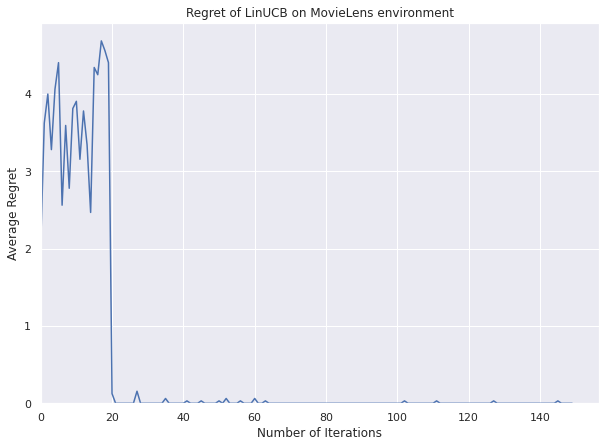

In [18]:
plot_regret(metrics['regret'], {'algorithm': 'LinUCB'})

## Linear Thomson Sampling policy

<center>
  <img src="https://raw.githubusercontent.com/pstanisl/mlprague-2021/main/img/lints_algorithm.png" alt="LinTS algorithm" width="400"/>
</center>

> A detailed explanation for the two above cases can be found in the paper
["Thompson Sampling for Contextual Bandits with Linear Payoffs"](http://proceedings.mlr.press/v28/agrawal13.pdf),
Shipra Agrawal, Navin Goyal, ICML 2013
, and its [supplementary material](http://proceedings.mlr.press/v28/agrawal13-supp.pdf).

In [19]:
class LinearTSPolicy(linear_bandit_policy.LinearBanditPolicy):
  """LinearTS policy is simplified version of LinearBanditPolicy from tf_agents."""

  def __init__(self,
               action_spec: types.BoundedTensorSpec,
               variable_collection: tf.Module,
               time_step_spec: Optional[types.TimeStep] = None,
               alpha: float = 1.0,
               tikhonov_weight: float = 1.0,
               name: Optional[Text] = None):
    super(LinearTSPolicy, self).__init__(
        action_spec,
        cov_matrix=variable_collection.cov_matrix_list,
        data_vector=variable_collection.data_vector_list,
        num_samples=variable_collection.num_samples_list,
        time_step_spec=time_step_spec,
        alpha=alpha,
        tikhonov_weight=tikhonov_weight,
        name=name)

  def _distribution(self, time_step, policy_state):
    observation = tf.nest.map_structure(lambda o: tf.cast(o, dtype=self._dtype),
                                        time_step.observation)
    
    current_observation = tf.reshape(
        observation, [-1, self._global_context_dim])

    est_rewards = []
    confidence_intervals = []

    for model_index in range(self._num_actions):
      # Compute confidence interval for action(i): x^T*A^-1*x
      # 1: A^-1*x -> A^-1x
      a_inv_x = linalg.conjugate_gradient_solve(
          self._cov_matrix[model_index] + self._tikhonov_weight *
          tf.eye(self._overall_context_dim, dtype=self._dtype),
          tf.linalg.matrix_transpose(current_observation))
      # 2: x^T*A^-1x -> confidence interval of action(i)
      ci = tf.reshape(
          tf.linalg.tensor_diag_part(tf.matmul(current_observation, a_inv_x)),
          [-1, 1])
      
      confidence_intervals.append(ci)
      est_mean_reward = tf.einsum('j,jk->k', self._data_vector[model_index],
                                  a_inv_x)
      est_rewards.append(est_mean_reward)
    # Sample from the Normapl distribution
    mu_sampler = tfp.distributions.Normal(
          loc=tf.stack(est_rewards, axis=-1),
          scale=self._alpha *
          tf.sqrt(tf.squeeze(tf.stack(confidence_intervals, axis=-1), axis=1)))
    rewards_for_argmax = mu_sampler.sample()
    # Choose the best action for every observation in the batch
    chosen_actions = tf.argmax(
        rewards_for_argmax,
        axis=-1,
        output_type=tf.nest.flatten(self._action_spec)[0].dtype)

    action_distributions = tfp.distributions.Deterministic(loc=chosen_actions)

    policy_info = policy_utilities.populate_policy_info(
        None, chosen_actions, rewards_for_argmax,
        tf.stack(est_rewards, axis=-1), self._emit_policy_info,
        False)

    return policy_step.PolicyStep(
        action_distributions, policy_state, policy_info)

Let's repeat the training with `LinearTSPolicy` and see the results.

In [20]:
batch_size =    32# @param {type:"integer"}
num_iterations =   150# @param {type:"integer"}
steps_per_loop =   2# @param {type:"integer"}
agent_alpha = 2.0  # @param {type: "number"}
tikhonov_weight = 0.001  # @param {type: "number"}

tf_env.reset()

agent = get_agent(
  tf_env,
  policy_class=LinearTSPolicy,
  tikhonov_weight=tikhonov_weight,
  alpha=agent_alpha
)

additional_metrics = get_metrics(tf_env)

metrics = run(
  tf_env, 
  agent, 
  iterations=num_iterations,
  steps_per_loop=steps_per_loop,
  additional_metrics=additional_metrics
)

linearTsPolicy


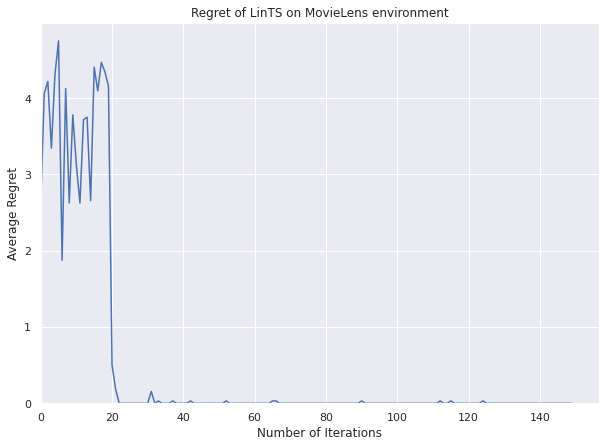

In [21]:
plot_regret(metrics['regret'], {'algorithm': 'LinTS'})